In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='6'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/ssd/al

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class, min_len):
    mean_class, std_class = loaded_mean_var_actions[cur_class]   
    prob = (cur_len * np.log(mean_class + 1e-5))
    prob = prob - mean_class
    prob = prob - np.sum(np.log(np.arange(1, cur_len, 1)))
    return prob

get_possion_prob(20, 20, 10)

0.48488744950308416

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            
            len_cur_class = ele - cur_boundary
            len_prob = get_possion_prob(len_cur_class, label_cur_ele.item(), cur_ele)
            prob_list.append((sum_window_class_1 + sum_window_class_2) + len_prob.item())
            
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob_list.detach().cpu().numpy()).item())
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [16]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [17]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [18]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [19]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [20]:
initialize_epoch = 15
expectation_cal_gap = 5
for epoch in range(1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            loss += 0.15 * torch.mean(torch.clamp(
                mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                max=16) * src_mask_mse[:, :, 1:])

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
                
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4], item_2)
                
                if i % 10 == 0:
                    pred = torch.argmax(prob, dim=2)
                    correct += float(torch.sum((pred == item_2) * src_mask).item())
                    total += float(torch.sum(src_mask).item())
                    print(f"Epoch {epoch} iter {i}, train acc. {correct * 100.0 / total: .3f}")
                    
        print(f"Epoch {epoch} After Expectation, train acc. {correct * 100.0 / total: .3f}")
        get_boundary_err()

    if epoch % 5 == 0:
        print("Calculating Validation Data Accuracy")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(testloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                
                pred = torch.argmax(predictions[-1], dim=1)
                correct += float(torch.sum((pred == item_2) * src_mask).item())
                total += float(torch.sum(src_mask).item())

        print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.625920295715332 Accuracy 1.0729173785279846
Training:: Epoch 0, Iteration 10, Current loss 14.152955055236816 Accuracy 2.6900162484202923
Training:: Epoch 0, Iteration 20, Current loss 13.58574390411377 Accuracy 4.047105004906771
Training:: Epoch 0, Iteration 30, Current loss 12.271114349365234 Accuracy 16.7036119441909
Training:: Epoch 0, Iteration 40, Current loss 12.344259262084961 Accuracy 5.686186411062852
Training:: Epoch 0, Iteration 50, Current loss 12.297993659973145 Accuracy 3.5779848290672303
Training:: Epoch 0, Iteration 60, Current loss 11.609221458435059 Accuracy 7.869181828329054
Training:: Epoch 0, Iteration 70, Current loss 11.46078872680664 Accuracy 4.962652784065188
Training:: Epoch 0, Iteration 80, Current loss 11.238487243652344 Accuracy 5.708691067931918
Training:: Epoch 0, Iteration 90, Current loss 11.219830513000488 Accuracy 8.624153976311337
Training:: Epoch 0, Iteration 100, Current loss 11.38

Training:: Epoch 5, Iteration 60, Current loss 5.292131423950195 Accuracy 33.40620031796502
Training:: Epoch 5, Iteration 70, Current loss 5.678159236907959 Accuracy 37.960069904146586
Training:: Epoch 5, Iteration 80, Current loss 4.507051944732666 Accuracy 39.75186104218362
Training:: Epoch 5, Iteration 90, Current loss 4.627745151519775 Accuracy 42.27840768021187
Training:: Epoch 5, Iteration 100, Current loss 5.503447532653809 Accuracy 29.65844924941468
Training:: Epoch 5, Iteration 110, Current loss 5.336030960083008 Accuracy 49.148999701403405
Training:: Epoch 5, Iteration 120, Current loss 6.111295223236084 Accuracy 31.657460966381073
Training:: Epoch 5, Iteration 130, Current loss 5.049837589263916 Accuracy 53.03627064840397
Training:: Epoch 5, Iteration 140, Current loss 6.09787654876709 Accuracy 30.758405003909303
Training:: Epoch 5, Iteration 150, Current loss 4.717557907104492 Accuracy 46.64050235478807
Calculating Validation Data Accuracy
Validation:: Epoch 5, Probability 

Training:: Epoch 10, Iteration 130, Current loss 2.7513437271118164 Accuracy 70.15178571428571
Training:: Epoch 10, Iteration 140, Current loss 2.613373279571533 Accuracy 64.89958837470375
Training:: Epoch 10, Iteration 150, Current loss 2.9976069927215576 Accuracy 69.30072976799913
Calculating Validation Data Accuracy
Validation:: Epoch 10, Probability Accuracy 52.96308571902059
Starting Training
Training:: Epoch 11, Iteration 0, Current loss 2.3486552238464355 Accuracy 72.9241422725842
Training:: Epoch 11, Iteration 10, Current loss 2.1554036140441895 Accuracy 77.3654372474912
Training:: Epoch 11, Iteration 20, Current loss 3.310319662094116 Accuracy 69.7398674541274
Training:: Epoch 11, Iteration 30, Current loss 2.3090906143188477 Accuracy 73.99930234586203
Training:: Epoch 11, Iteration 40, Current loss 2.146963357925415 Accuracy 74.07871101192096
Training:: Epoch 11, Iteration 50, Current loss 2.9871954917907715 Accuracy 61.690622861054074
Training:: Epoch 11, Iteration 60, Curre

Epoch 15 iter 60, train acc.  73.646
Epoch 15 iter 70, train acc.  72.289
Epoch 15 iter 80, train acc.  72.738
Epoch 15 iter 90, train acc.  72.903
Epoch 15 iter 100, train acc.  73.377
Epoch 15 iter 110, train acc.  73.748
Epoch 15 iter 120, train acc.  74.128
Epoch 15 iter 130, train acc.  74.553
Epoch 15 iter 140, train acc.  74.761
Epoch 15 iter 150, train acc.  75.421
Epoch 15 After Expectation, train acc.  75.421
Train Boundary avergage error = 140.045
Train From boundary avergage accuracy = 85.348
Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 57.21247462402121
Starting Training
Training:: Epoch 16, Iteration 0, Current loss 5.463314533233643 Accuracy 69.44555245313123
Training:: Epoch 16, Iteration 10, Current loss 4.2174973487854 Accuracy 76.8056898218478
Training:: Epoch 16, Iteration 20, Current loss 4.266139984130859 Accuracy 71.55767541107066
Training:: Epoch 16, Iteration 30, Current loss 8.12350082397461 Accuracy 58.54477111021614
Traini

KeyboardInterrupt: 

In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [28]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [35]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(video_id_boundary_frames, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [ ]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        
        probs = get_ensemble_out([y, y_list])
        features = torch.log(probs + 1e-4).permute(0,2,1)
        get_estimated_boundary(features, item[1], item[4])
get_boundary_err()

In [ ]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = features[idx]
    cur_vidid = item[4][idx]

    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid + ".txt"], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    bound_list = torch.tensor(boundaries_dict[cur_vidid], dtype=selected_frames.dtype, device=selected_frames.device)

    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)

    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat)

(0, 1)

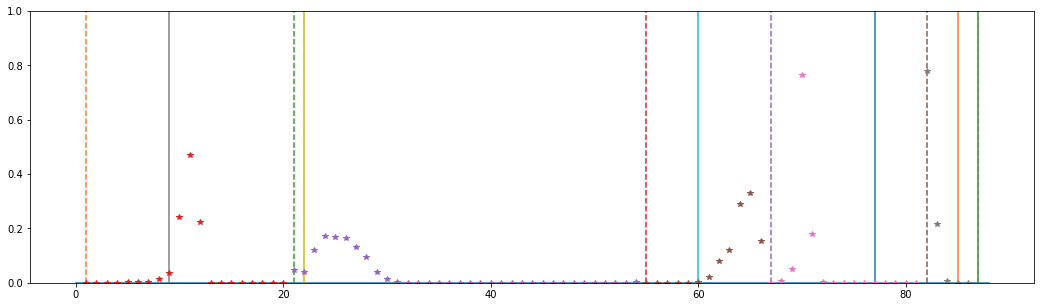

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob = segment / torch.sum(segment)
    prob = prob.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [49]:
np.max(prob), np.min(prob)

(5.1846523, 2.9907308)

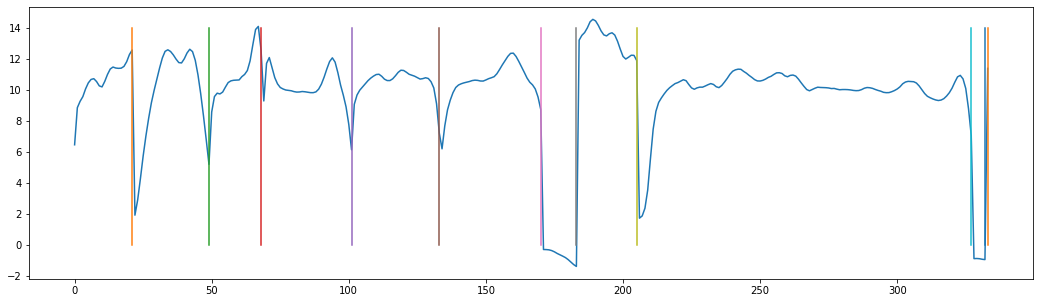

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss